# **Imports**

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency
from datetime import datetime

# **Data Sourcing and Data Description**
### Source: Uber stock data from Yahoo Finance (https://finance.yahoo.com/quote/UBER/history/)
### Description: Daily stock prices and volume for Uber Technologies, Inc.
### Variables: Date (text), Adj Close, Close, High, Low, Open (float), Volume (int)

In [81]:
file_path = '/content/uber_stock_data.csv'
df = pd.read_csv(file_path)
df.head()
print("Dataset Summary:")
print(df.info())  # Structure: 1444 entries, 7 columns

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444 entries, 0 to 1443
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1444 non-null   object 
 1   Adj Close  1444 non-null   float64
 2   Close      1444 non-null   float64
 3   High       1444 non-null   float64
 4   Low        1444 non-null   float64
 5   Open       1444 non-null   float64
 6   Volume     1444 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 79.1+ KB
None


In [82]:
print("\nFirst 5 Rows:")
print(df.head())


First 5 Rows:
         Date  Adj Close      Close       High        Low       Open  \
0  10-05-2019  41.570000  41.570000  45.000000  41.060001  42.000000   
1  13-05-2019  37.099998  37.099998  39.240002  36.080002  38.790001   
2  14-05-2019  39.959999  39.959999  39.959999  36.849998  38.310001   
3  15-05-2019  41.290001  41.290001  41.880001  38.950001  39.369999   
4  16-05-2019  43.000000  43.000000  44.060001  41.250000  41.480000   

      Volume  
0  186322500  
1   79442400  
2   46661100  
3   36086100  
4   38115500  


In [83]:
print("\nNumerical Summary:")
print(df.describe())


Numerical Summary:
         Adj Close        Close         High          Low         Open  \
count  1444.000000  1444.000000  1444.000000  1444.000000  1444.000000   
mean     44.465374    44.465374    45.287511    43.643301    44.493022   
std      15.594262    15.594262    15.740825    15.482652    15.643967   
min      14.820000    14.820000    17.799999    13.710000    15.960000   
25%      31.930000    31.930000    32.653749    31.181250    31.867499   
50%      41.355001    41.355001    41.910000    40.518499    41.215000   
75%      54.719999    54.719999    55.635001    53.597502    54.664999   
max      86.339996    86.339996    87.000000    84.180000    85.639999   

             Volume  
count  1.444000e+03  
mean   2.429800e+07  
std    1.774084e+07  
min    3.380000e+06  
25%    1.498905e+07  
50%    2.036965e+07  
75%    2.843280e+07  
max    3.642318e+08  


# **Data Cleaning**

In [84]:
# Check for missing values
print("\n--- Missing Values ---")
print(df.isnull().sum()) # No missing values expected
# Remove missing values if any
df = df.dropna()

# Check for duplicates
print("\nDuplicate Rows:", df.duplicated().sum())  # No duplicates expected
df = df.drop_duplicates()

# Format Date column
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
# Check for invalid dates
print("\nInvalid Dates:", df['Date'].isna().sum())  # Should be 0
df = df.dropna(subset=['Date'])

# Check for outliers in numerical columns using IQR
numerical_cols = ['Close', 'Volume']
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    print(f"\nOutliers in {col}:", len(outliers), "rows")
    # Optional: Remove outliers (commented out to preserve data)
    # df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


--- Missing Values ---
Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

Duplicate Rows: 0

Invalid Dates: 0

Outliers in Close: 0 rows

Outliers in Volume: 83 rows


Outliers were detected in Volume using the IQR method, but were retained in the dataset to preserve the natural volatility of stock market behavior.

# **Data Visualization**

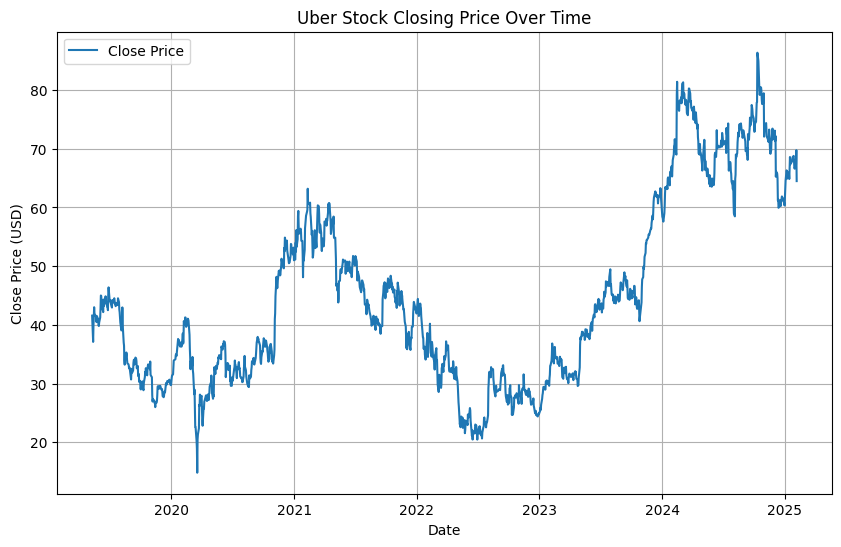

Conclusion: The line plot shows general trends in Uber's stock price, with periods of volatility.


In [85]:
# Line Plot
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title('Uber Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()
print("Conclusion: The line plot shows general trends in Uber's stock price, with periods of volatility.")

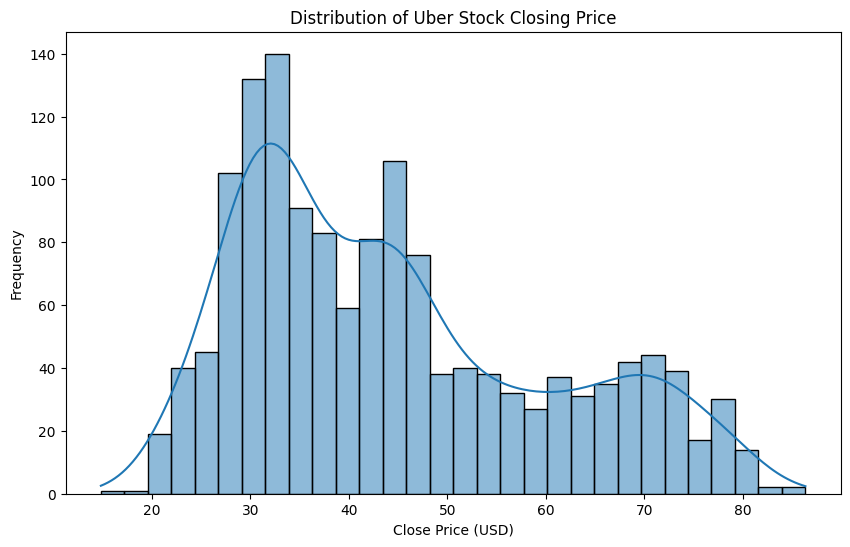

Conclusion: The histogram suggests a right-skewed distribution of closing prices.


In [86]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], kde=True, bins=30)
plt.title('Distribution of Uber Stock Closing Price')
plt.xlabel('Close Price (USD)')
plt.ylabel('Frequency')
plt.show()
print("Conclusion: The histogram suggests a right-skewed distribution of closing prices.")

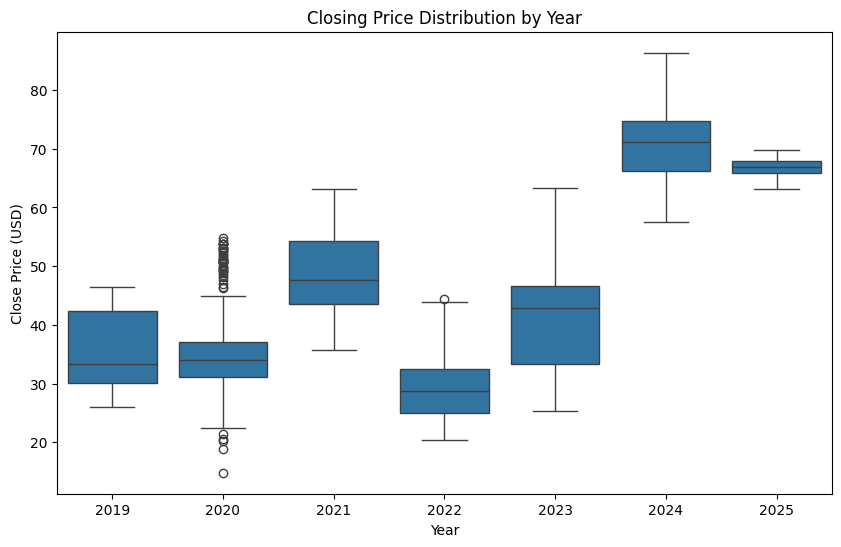

Conclusion: Box plots reveal increasing median prices over years, with potential outliers in later years.


In [87]:
# Box Plot by Year
df['Year'] = df['Date'].dt.year
plt.figure(figsize=(10, 6))
sns.boxplot(x='Year', y='Close', data=df)
plt.title('Closing Price Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Close Price (USD)')
plt.show()
print("Conclusion: Box plots reveal increasing median prices over years, with potential outliers in later years.")

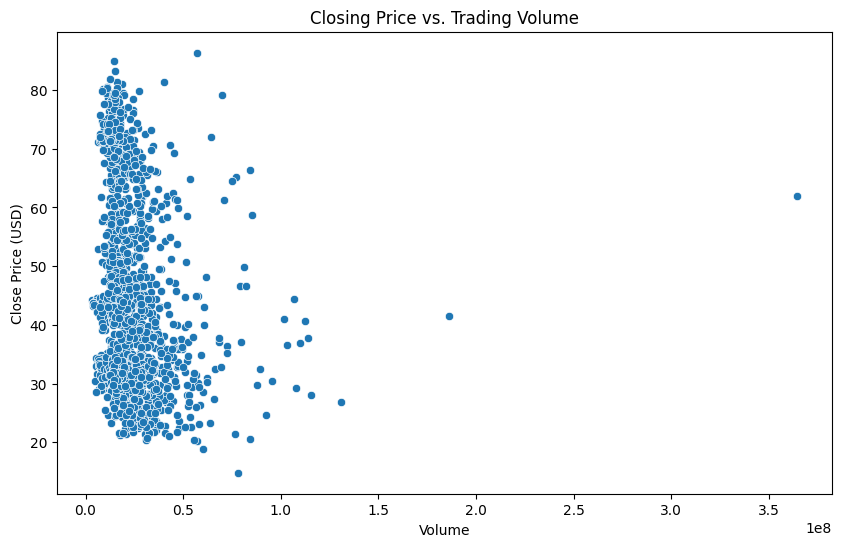

Conclusion: The scatter plot shows no clear linear relationship between volume and price.


In [88]:
# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Volume', y='Close', data=df)
plt.title('Closing Price vs. Trading Volume')
plt.xlabel('Volume')
plt.ylabel('Close Price (USD)')
plt.show()
print("Conclusion: The scatter plot shows no clear linear relationship between volume and price.")

<ipython-input-89-479399ac909e>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Close'], shade=True)


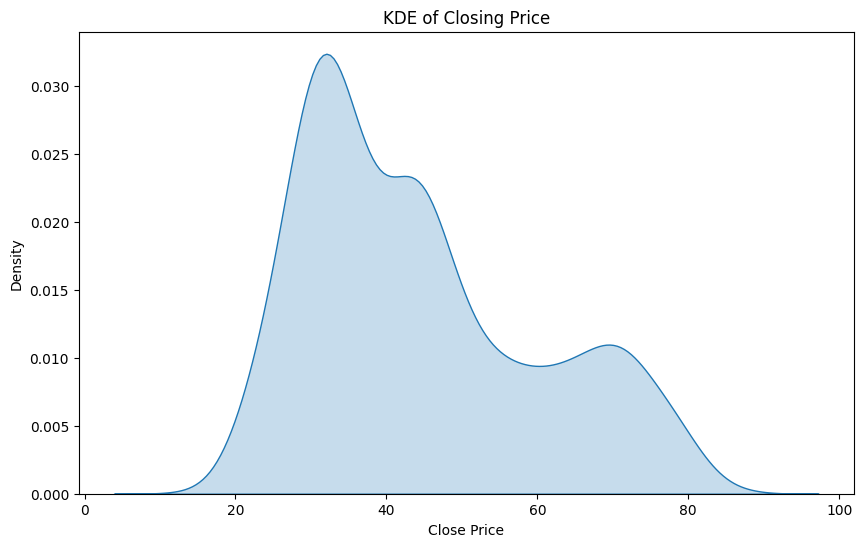

In [89]:
# KDE Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Close'], shade=True)
plt.title("KDE of Closing Price")
plt.xlabel("Close Price")
plt.show()

# **Summary Statistics**

In [90]:
stats_summary = {}
for col in ['Close', 'Volume']:
    stats_summary[col] = {
        'Mean': df[col].mean(),
        'Median': df[col].median(),
        'Mode': df[col].mode()[0],
        'Range': df[col].max() - df[col].min(),
        'Variance': df[col].var(),
        'Std': df[col].std(),
        'Q1': df[col].quantile(0.25),
        'Q2': df[col].quantile(0.50),
        'Q3': df[col].quantile(0.75),
        'Min': df[col].min(),
        'Max': df[col].max()
    }
print("\nSummary Statistics:")
for col, stats in stats_summary.items():
    print(f"\n{col}:")
    for stat, value in stats.items():
        print(f"  {stat}: {value:.2f}")


Summary Statistics:

Close:
  Mean: 44.47
  Median: 41.36
  Mode: 30.68
  Range: 71.52
  Variance: 243.18
  Std: 15.59
  Q1: 31.93
  Q2: 41.36
  Q3: 54.72
  Min: 14.82
  Max: 86.34

Volume:
  Mean: 24298002.88
  Median: 20369650.00
  Mode: 11283600.00
  Range: 360851800.00
  Variance: 314737235515814.25
  Std: 17740835.25
  Q1: 14989050.00
  Q2: 20369650.00
  Q3: 28432800.00
  Min: 3380000.00
  Max: 364231800.00


# **Univariate Analysis for Close Price and Distribution Analysis**

Skewness: 0.673394420001768
Kurtosis: -0.6011381803552771

Analyzing Close...


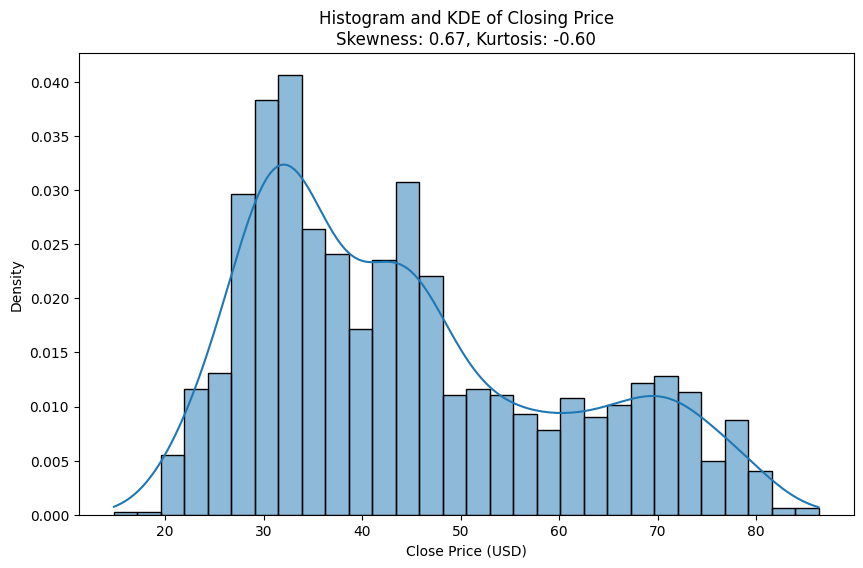

Shapiro-Wilk Test: Statistic = 0.9288385180046851 , p-value = 1.2370198254284775e-25
Conclusion: p-value < 0.05 indicates Close is not normally distributed.


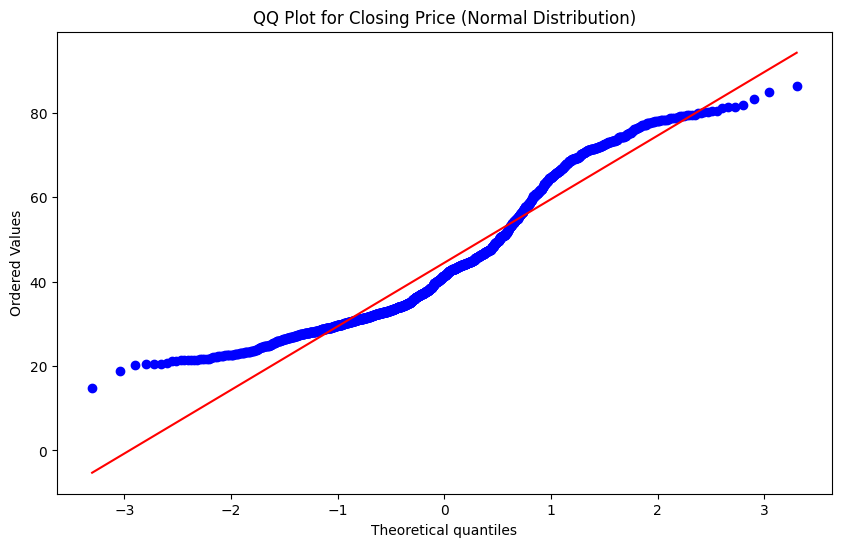

Conclusion: The QQ plot confirms deviation from normality, especially in tails.


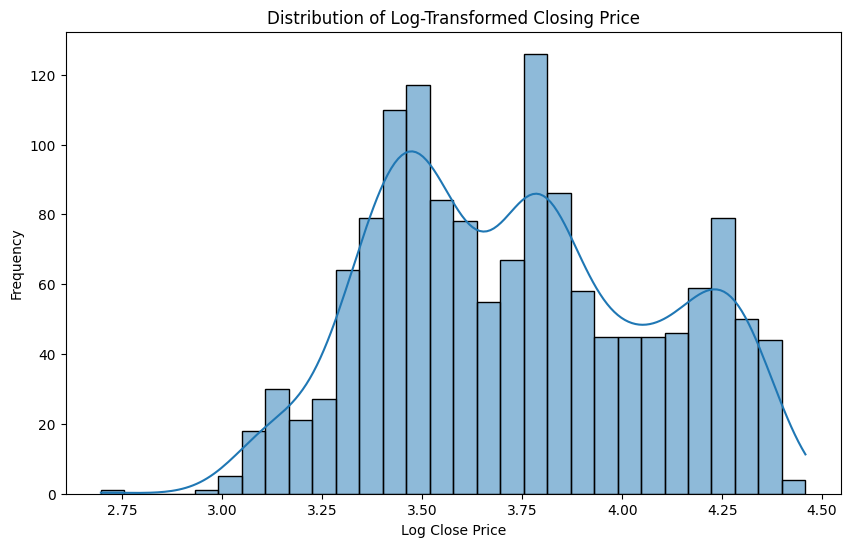

Shapiro-Wilk Test (Log-Close): Statistic = 0.971650663241869 , p-value = 3.043861944691911e-16
Conclusion: Log transformation improves normality but may not achieve it fully.


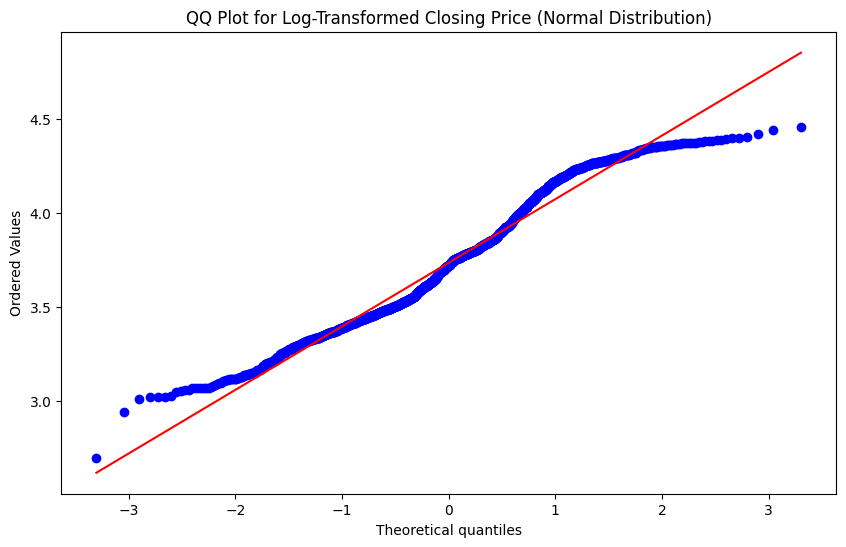

Conclusion: The QQ plot for Log-Close shows improved alignment with the normal distribution, though deviations in the tails may persist.


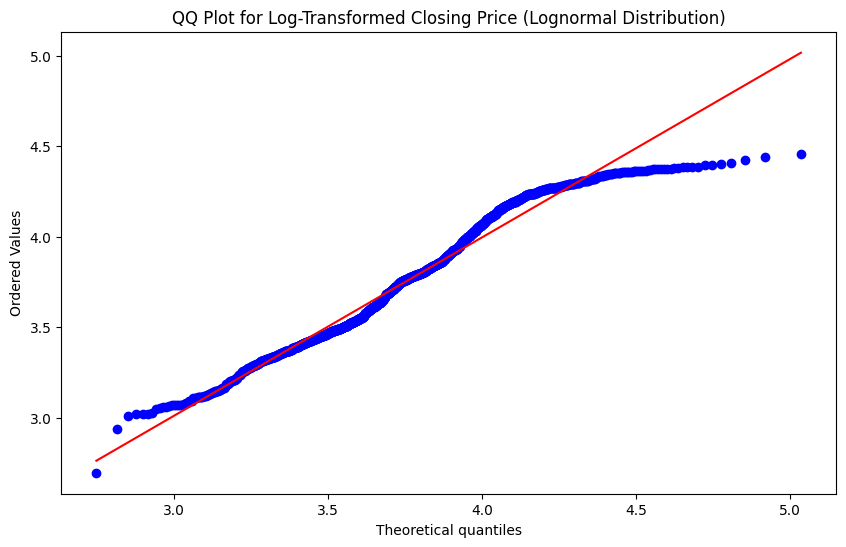

Conclusion: The QQ plot for Log-Close against Lognormal distribution shows alignment, with possible deviations at the extremes.


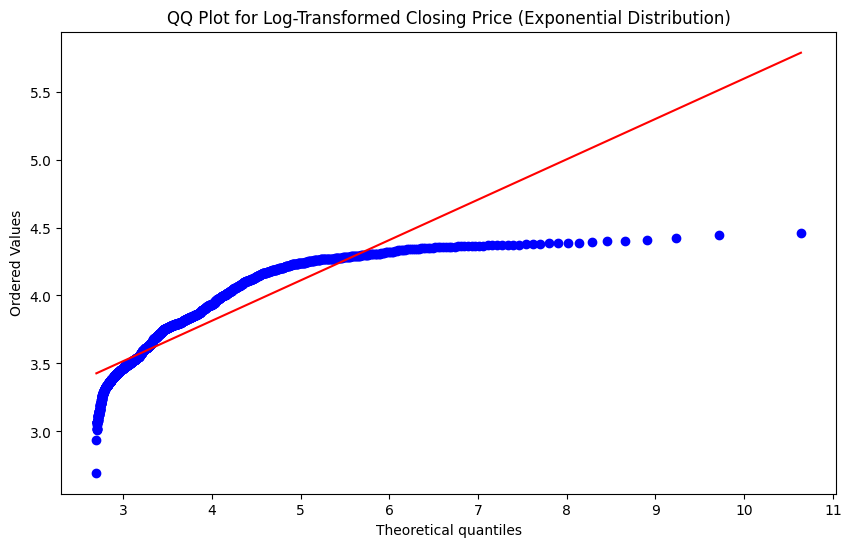

Conclusion: The QQ plot for Log-Close against Exponential distribution typically shows poor fit due to systematic deviations.


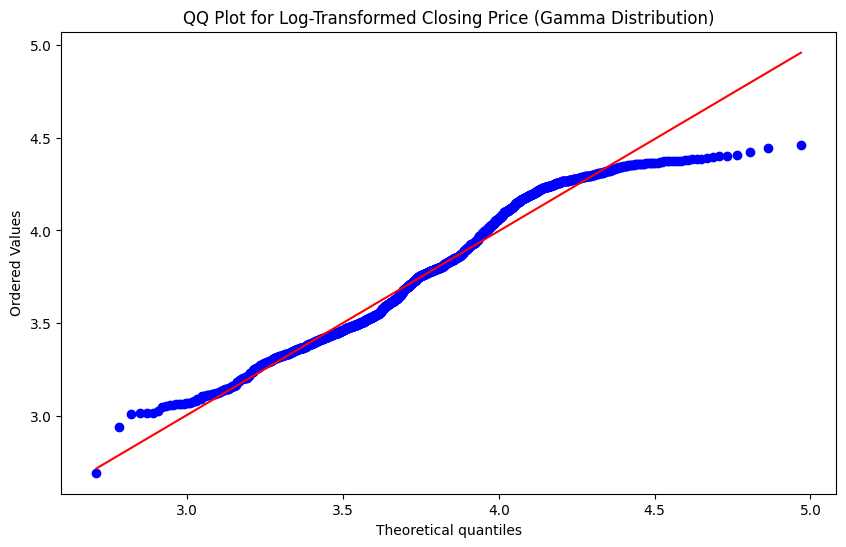

Conclusion: The QQ plot for Log-Close against Gamma distribution shows reasonable fit in the middle but may deviate at the tails.


In [91]:
# Skewness and Kurtosis
close_skew = df['Close'].skew()
close_kurt = df['Close'].kurtosis()
print("Skewness:", close_skew)
print("Kurtosis:", close_kurt)

# Histogram with KDE for Close
print("\nAnalyzing Close...")
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], kde=True, stat='density', bins=30)
plt.title(f'Histogram and KDE of Closing Price\nSkewness: {close_skew:.2f}, Kurtosis: {close_kurt:.2f}')
plt.xlabel('Close Price (USD)')
plt.ylabel('Density')
plt.show()

# Normality Test (Shapiro-Wilk)
try:
    shapiro_stat, shapiro_p = scipy.stats.shapiro(df['Close'])
    print("Shapiro-Wilk Test: Statistic =", shapiro_stat, ", p-value =", shapiro_p)
    print("Conclusion: p-value < 0.05 indicates Close is not normally distributed.")
except ValueError as e:
    print("Shapiro-Wilk Test failed:", e)

# QQ Plot for Original Close Price (Normal Distribution)
plt.figure(figsize=(10, 6))
scipy.stats.probplot(df['Close'], dist="norm", plot=plt)
plt.title('QQ Plot for Closing Price (Normal Distribution)')
plt.show()
print("Conclusion: The QQ plot confirms deviation from normality, especially in tails.")

# Log Transformation
try:
    df['Log_Close'] = np.log(df['Close'].clip(lower=1e-10))  # Avoid log(0) or negative
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Log_Close'], kde=True, bins=30)
    plt.title('Distribution of Log-Transformed Closing Price')
    plt.xlabel('Log Close Price')
    plt.ylabel('Frequency')
    plt.show()
    shapiro_stat_log, shapiro_p_log = scipy.stats.shapiro(df['Log_Close'])
    print("Shapiro-Wilk Test (Log-Close): Statistic =", shapiro_stat_log, ", p-value =", shapiro_p_log)
    print("Conclusion: Log transformation improves normality but may not achieve it fully.")

    # QQ Plot for Log-Transformed Close Price (Normal Distribution)
    plt.figure(figsize=(10, 6))
    scipy.stats.probplot(df['Log_Close'], dist="norm", plot=plt)
    plt.title('QQ Plot for Log-Transformed Closing Price (Normal Distribution)')
    plt.show()
    print("Conclusion: The QQ plot for Log-Close shows improved alignment with the normal distribution, though deviations in the tails may persist.")

    # Fit parameters for Lognormal, Exponential, and Gamma distributions
    # Lognormal: Use shape, loc, and scale
    lognormal_params = scipy.stats.lognorm.fit(df['Log_Close'], floc=0)
    # Exponential: Use loc and scale
    exponential_params = scipy.stats.expon.fit(df['Log_Close'])
    # Gamma: Use shape (a), loc, and scale
    gamma_params = scipy.stats.gamma.fit(df['Log_Close'], floc=0)

    # QQ Plot for Log-Transformed Close Price (Lognormal Distribution)
    plt.figure(figsize=(10, 6))
    scipy.stats.probplot(df['Log_Close'], dist=scipy.stats.lognorm(*lognormal_params), plot=plt)
    plt.title('QQ Plot for Log-Transformed Closing Price (Lognormal Distribution)')
    plt.show()
    print("Conclusion: The QQ plot for Log-Close against Lognormal distribution shows alignment, with possible deviations at the extremes.")

    # QQ Plot for Log-Transformed Close Price (Exponential Distribution)
    plt.figure(figsize=(10, 6))
    scipy.stats.probplot(df['Log_Close'], dist=scipy.stats.expon(*exponential_params), plot=plt)
    plt.title('QQ Plot for Log-Transformed Closing Price (Exponential Distribution)')
    plt.show()
    print("Conclusion: The QQ plot for Log-Close against Exponential distribution typically shows poor fit due to systematic deviations.")

    # QQ Plot for Log-Transformed Close Price (Gamma Distribution)
    plt.figure(figsize=(10, 6))
    scipy.stats.probplot(df['Log_Close'], dist=scipy.stats.gamma(*gamma_params), plot=plt)
    plt.title('QQ Plot for Log-Transformed Closing Price (Gamma Distribution)')
    plt.show()
    print("Conclusion: The QQ plot for Log-Close against Gamma distribution shows reasonable fit in the middle but may deviate at the tails.")
except ValueError as e:
    print("Log Transformation or Shapiro-Wilk Test (Log-Close) failed:", e)

# **95% Confidence Interval for Mean Close Price**

In [92]:
import pandas as pd
import scipy.stats
import numpy as np

# Assuming df is the DataFrame with Uber stock data (Close)

# Calculate 95% CI for mean Close price
mean_close = df['Close'].mean()
sem_close = scipy.stats.sem(df['Close'])
ci = scipy.stats.t.interval(0.95, len(df['Close'])-1, loc=mean_close, scale=sem_close)

# Print formatted result
print(f"\n95% Confidence Interval for Mean Close Price: (${ci[0]:.2f}, ${ci[1]:.2f})")


95% Confidence Interval for Mean Close Price: ($43.66, $45.27)


# **Univariate Analysis for Volume and Distribution Analysis**


Univariate Analysis for Volume:
Skewness: 6.808582993692506
Kurtosis: 101.62290650706322

Analyzing Volume...


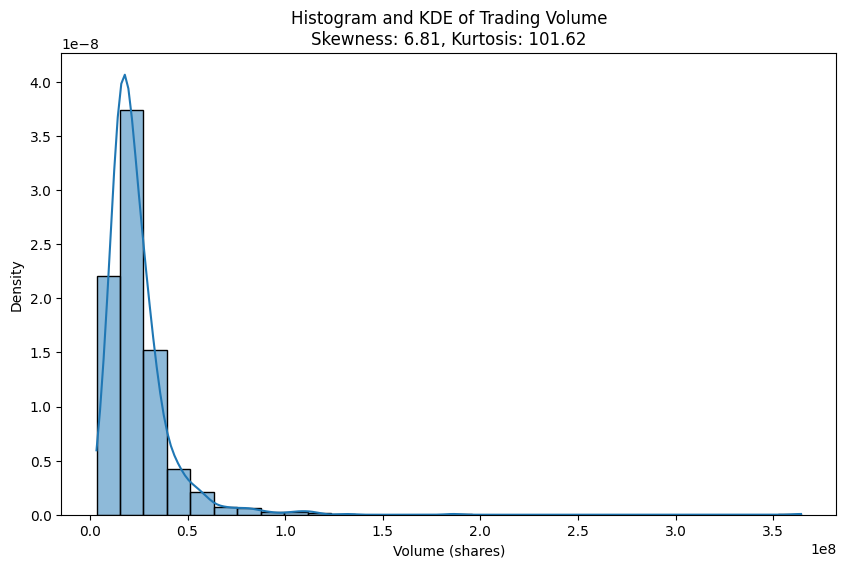

Shapiro-Wilk Test: Statistic = 0.6319235159496324 , p-value = 3.934337227839255e-48
Conclusion: p-value < 0.05 indicates Volume is not normally distributed.


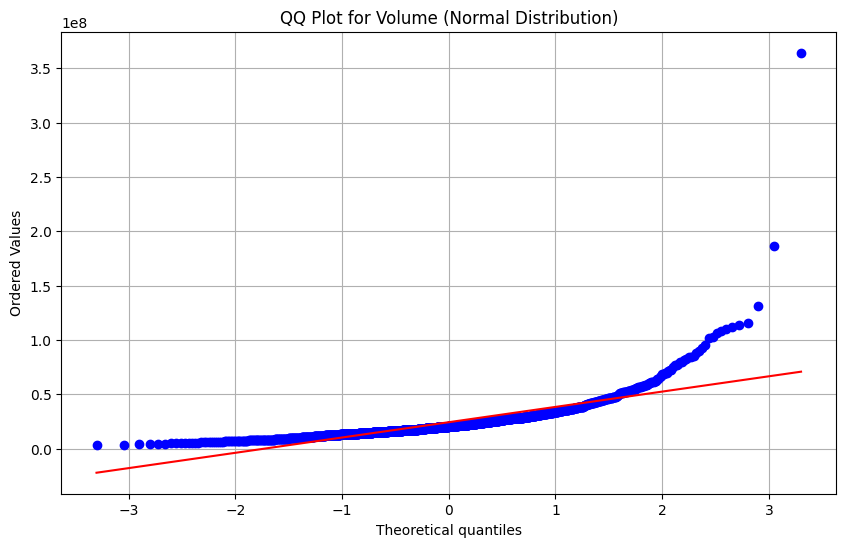

Conclusion: QQ plot shows heavy right tail — Volume is not normally distributed.


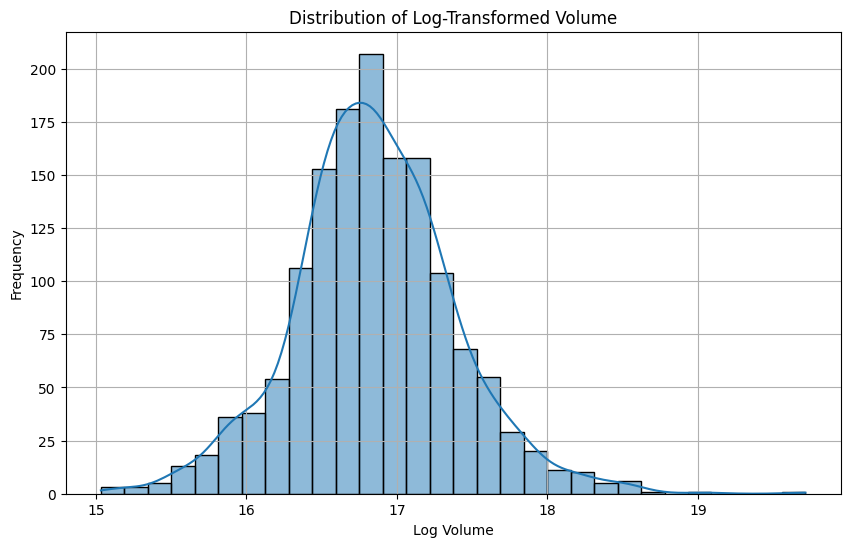

Shapiro-Wilk Test (Log-Volume): Statistic = 0.9886353309584697 , p-value = 3.506577924071286e-09
Conclusion: Log transformation improves normality, but distribution may still be skewed.


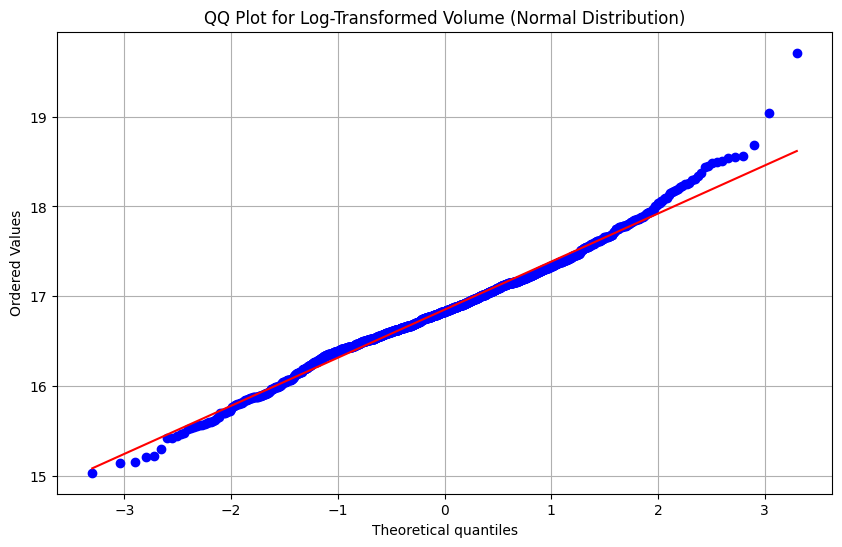

Conclusion: The QQ plot for Log-Volume shows improved alignment with the normal distribution, though deviations in the tails may persist.


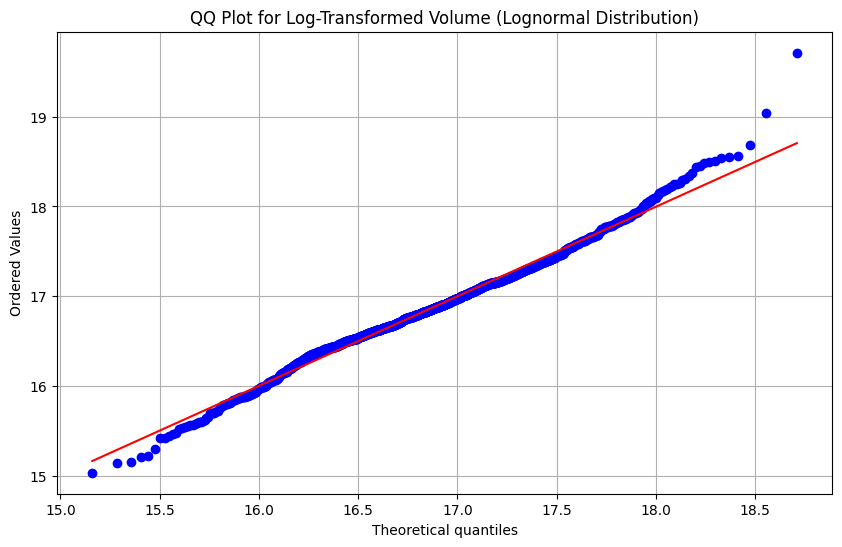

Conclusion: The QQ plot for Log-Volume against Lognormal distribution shows alignment, with possible deviations at the extremes.


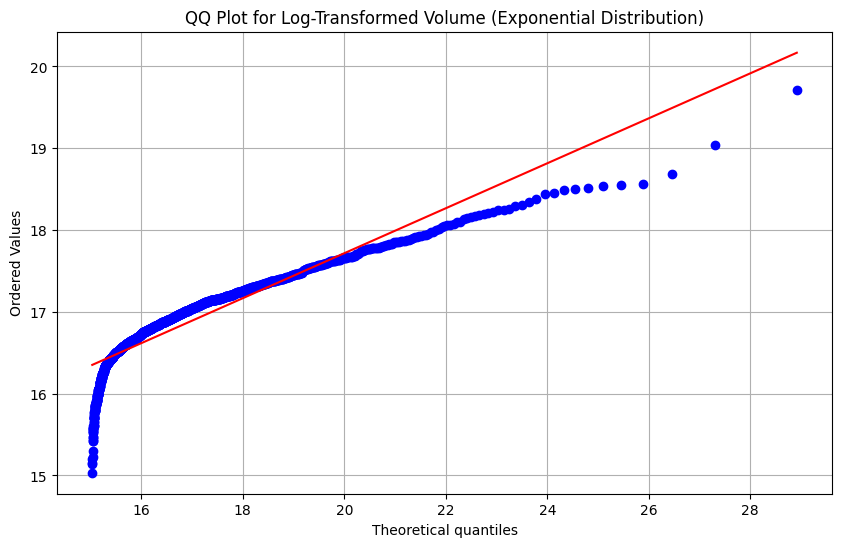

Conclusion: The QQ plot for Log-Volume against Exponential distribution typically shows poor fit due to systematic deviations.


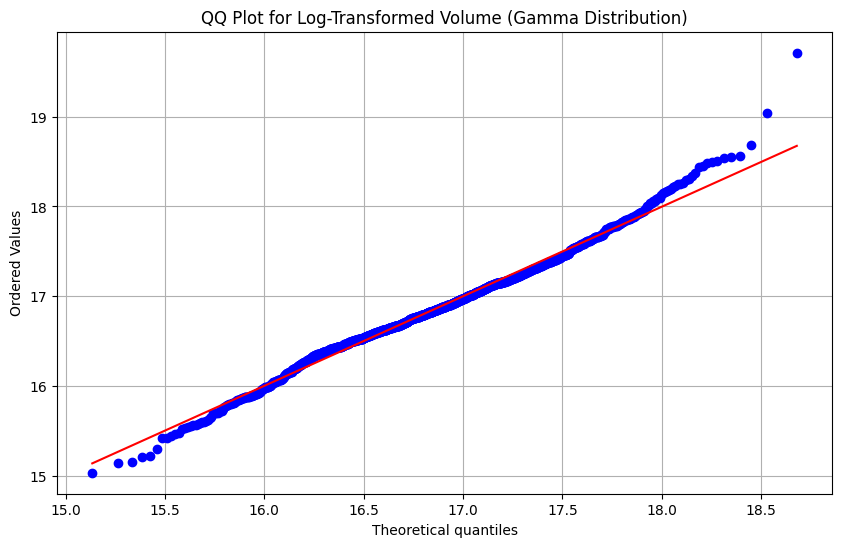

Conclusion: The QQ plot for Log-Volume against Gamma distribution shows reasonable fit in the middle but may deviate at the tails.


In [93]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is the DataFrame containing the Uber stock data with 'Volume' column

print("\nUnivariate Analysis for Volume:")

# Skewness and Kurtosis
volume_skew = df['Volume'].skew()
volume_kurt = df['Volume'].kurtosis()
print("Skewness:", volume_skew)
print("Kurtosis:", volume_kurt)

# Histogram with KDE for Volume
print("\nAnalyzing Volume...")
plt.figure(figsize=(10, 6))
sns.histplot(df['Volume'], kde=True, stat='density', bins=30)
plt.title(f'Histogram and KDE of Trading Volume\nSkewness: {volume_skew:.2f}, Kurtosis: {volume_kurt:.2f}')
plt.xlabel('Volume (shares)')
plt.ylabel('Density')
plt.show()

# Normality Test (Shapiro-Wilk)
try:
    shapiro_stat_vol, shapiro_p_vol = scipy.stats.shapiro(df['Volume'])
    print("Shapiro-Wilk Test: Statistic =", shapiro_stat_vol, ", p-value =", shapiro_p_vol)
    print("Conclusion: p-value < 0.05 indicates Volume is not normally distributed.")
except ValueError as e:
    print("Shapiro-Wilk Test failed:", e)

# QQ Plot for Volume (Normal Distribution)
plt.figure(figsize=(10, 6))
scipy.stats.probplot(df['Volume'], dist="norm", plot=plt)
plt.title('QQ Plot for Volume (Normal Distribution)')
plt.grid(True)
plt.show()
print("Conclusion: QQ plot shows heavy right tail — Volume is not normally distributed.")

# Log Transformation
try:
    df['Log_Volume'] = np.log(df['Volume'].clip(lower=1e-10))  # Avoid log(0)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Log_Volume'], kde=True, bins=30)
    plt.title('Distribution of Log-Transformed Volume')
    plt.xlabel('Log Volume')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Shapiro-Wilk test on log-transformed Volume
    shapiro_stat_log_vol, shapiro_p_log_vol = scipy.stats.shapiro(df['Log_Volume'])
    print("Shapiro-Wilk Test (Log-Volume): Statistic =", shapiro_stat_log_vol, ", p-value =", shapiro_p_log_vol)
    print("Conclusion: Log transformation improves normality, but distribution may still be skewed.")

    # QQ Plot for Log-Transformed Volume (Normal Distribution)
    plt.figure(figsize=(10, 6))
    scipy.stats.probplot(df['Log_Volume'], dist="norm", plot=plt)
    plt.title('QQ Plot for Log-Transformed Volume (Normal Distribution)')
    plt.grid(True)
    plt.show()
    print("Conclusion: The QQ plot for Log-Volume shows improved alignment with the normal distribution, though deviations in the tails may persist.")

    # Fit parameters for Lognormal, Exponential, and Gamma distributions
    # Lognormal: Use shape, loc, and scale
    lognormal_params = scipy.stats.lognorm.fit(df['Log_Volume'], floc=0)
    # Exponential: Use loc and scale
    exponential_params = scipy.stats.expon.fit(df['Log_Volume'])
    # Gamma: Use shape (a), loc, and scale
    gamma_params = scipy.stats.gamma.fit(df['Log_Volume'], floc=0)

    # QQ Plot for Log-Transformed Volume (Lognormal Distribution)
    plt.figure(figsize=(10, 6))
    scipy.stats.probplot(df['Log_Volume'], dist=scipy.stats.lognorm(*lognormal_params), plot=plt)
    plt.title('QQ Plot for Log-Transformed Volume (Lognormal Distribution)')
    plt.grid(True)
    plt.show()
    print("Conclusion: The QQ plot for Log-Volume against Lognormal distribution shows alignment, with possible deviations at the extremes.")

    # QQ Plot for Log-Transformed Volume (Exponential Distribution)
    plt.figure(figsize=(10, 6))
    scipy.stats.probplot(df['Log_Volume'], dist=scipy.stats.expon(*exponential_params), plot=plt)
    plt.title('QQ Plot for Log-Transformed Volume (Exponential Distribution)')
    plt.grid(True)
    plt.show()
    print("Conclusion: The QQ plot for Log-Volume against Exponential distribution typically shows poor fit due to systematic deviations.")

    # QQ Plot for Log-Transformed Volume (Gamma Distribution)
    plt.figure(figsize=(10, 6))
    scipy.stats.probplot(df['Log_Volume'], dist=scipy.stats.gamma(*gamma_params), plot=plt)
    plt.title('QQ Plot for Log-Transformed Volume (Gamma Distribution)')
    plt.grid(True)
    plt.show()
    print("Conclusion: The QQ plot for Log-Volume against Gamma distribution shows reasonable fit in the middle but may deviate at the tails.")
except ValueError as e:
    print("Log Transformation or Shapiro-Wilk Test (Log-Volume) failed:", e)

# **Correlation Analysis**

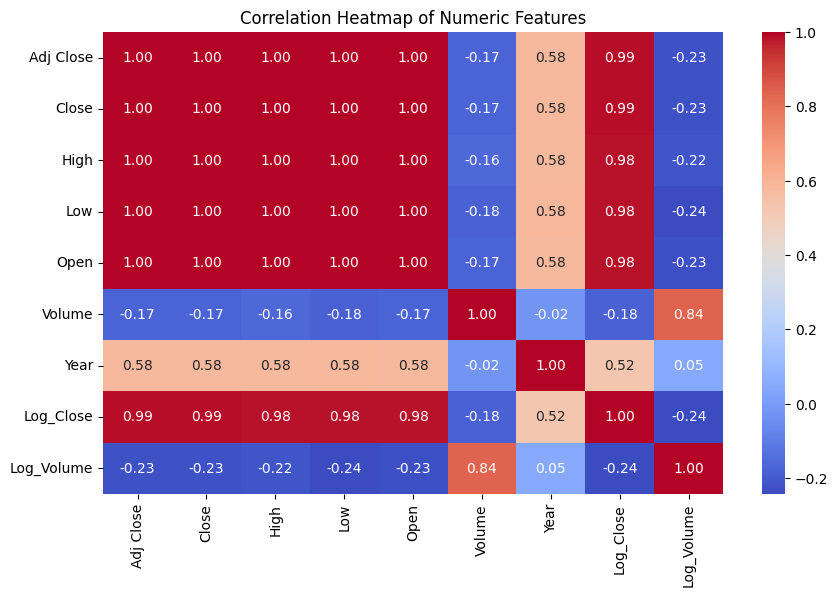

In [94]:
# Correlation Heatmap
plt.figure(figsize=(10,6))
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

# **T-Tests and Hypotheses Testing**

T-Tests for Weekday vs. Weekend and High vs. Low Volume Days

This section performs independent t-tests to:
1. Compare mean log-transformed closing price (`Log_Close`) and trading volume (`Log_Volume`) between weekdays (Monday–Thursday) and the end-of-week trading day (Friday, as a proxy for 'weekend').
2. Compare mean `Log_Close` and `Log_Volume` between High and Low volume days (based on `Volume_Level` tertiles, excluding Medium).



--- T-Test: Log_Close (Weekday vs. Weekend) ---
H₀ (Null Hypothesis): There is no significant difference in mean Log_Close between weekdays and weekends.
H₁ (Alternative Hypothesis): There is a significant difference in mean Log_Close between weekdays and weekends.

T-statistic: -0.030
P-value: 0.976

Conclusion: Since p-value ≥ 0.05, we fail to reject the null hypothesis (H₀).
Mean Log_Close is NOT significantly different between weekdays and weekends.

--- T-Test: Log_Volume (Weekday vs. Weekend) ---
H₀ (Null Hypothesis): There is no significant difference in mean Log_Volume between weekdays and weekends.
H₁ (Alternative Hypothesis): There is a significant difference in mean Log_Volume between weekdays and weekends.

T-statistic: 0.518
P-value: 0.605

Conclusion: Since p-value ≥ 0.05, we fail to reject the null hypothesis (H₀).
Mean Log_Volume is NOT significantly different between weekdays and weekends.

Visualizing Weekday vs. Weekend differences...


<ipython-input-95-cfb966be6ff9>:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Weekday (Mon–Thu)', 'Weekend (Fri)'])
<ipython-input-95-cfb966be6ff9>:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Weekday (Mon–Thu)', 'Weekend (Fri)'])


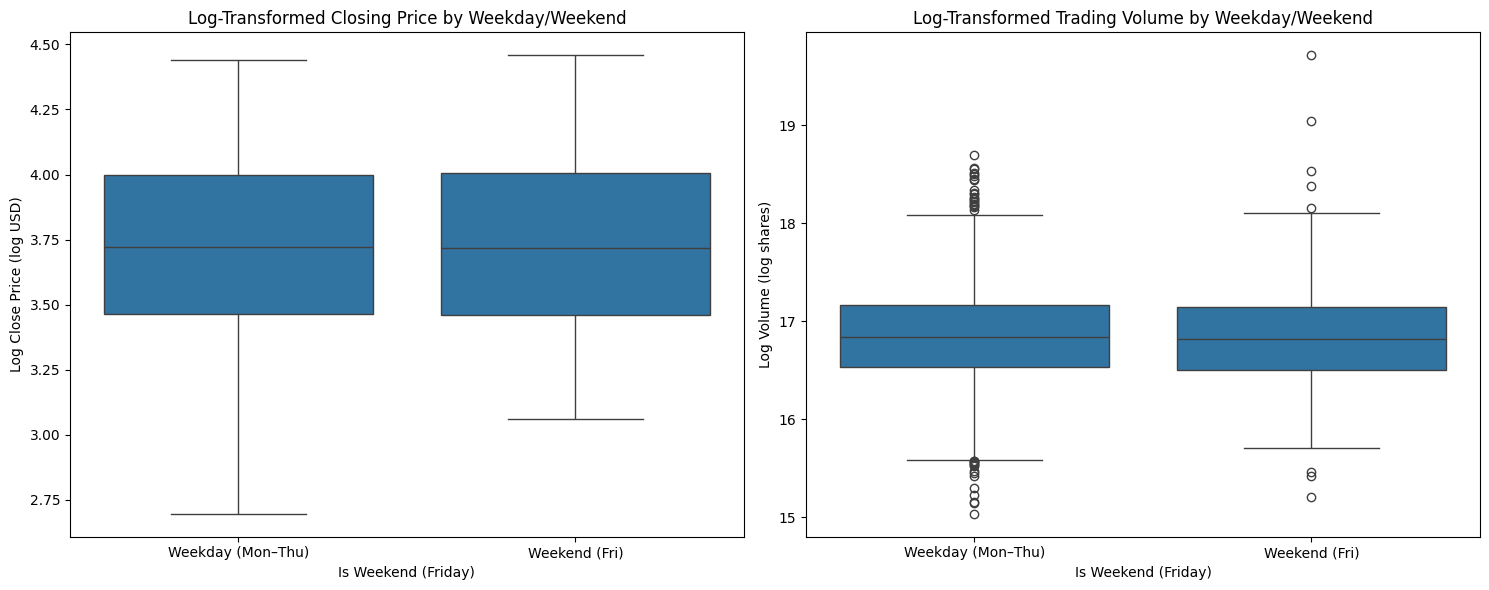


--- T-Test: Log_Close (High vs. Low Volume Days) ---
H₀ (Null Hypothesis): There is no significant difference in mean Log_Close between high and low volume days.
H₁ (Alternative Hypothesis): There is a significant difference in mean Log_Close between high and low volume days.

T-statistic: -10.830
P-value: 7.1880e-26

Conclusion: Since p-value < 0.05, we reject the null hypothesis (H₀).
Mean Log_Close is significantly different between high and low volume days.

--- T-Test: Log_Volume (High vs. Low Volume Days) ---
H₀ (Null Hypothesis): There is no significant difference in mean Log_Volume between high and low volume days.
H₁ (Alternative Hypothesis): There is a significant difference in mean Log_Volume between high and low volume days.

T-statistic: 52.750
P-value: 3.5160e-284

Conclusion: Since p-value < 0.05, we reject the null hypothesis (H₀).
Mean Log_Volume is significantly different between high and low volume days.

Visualizing High vs. Low Volume differences...


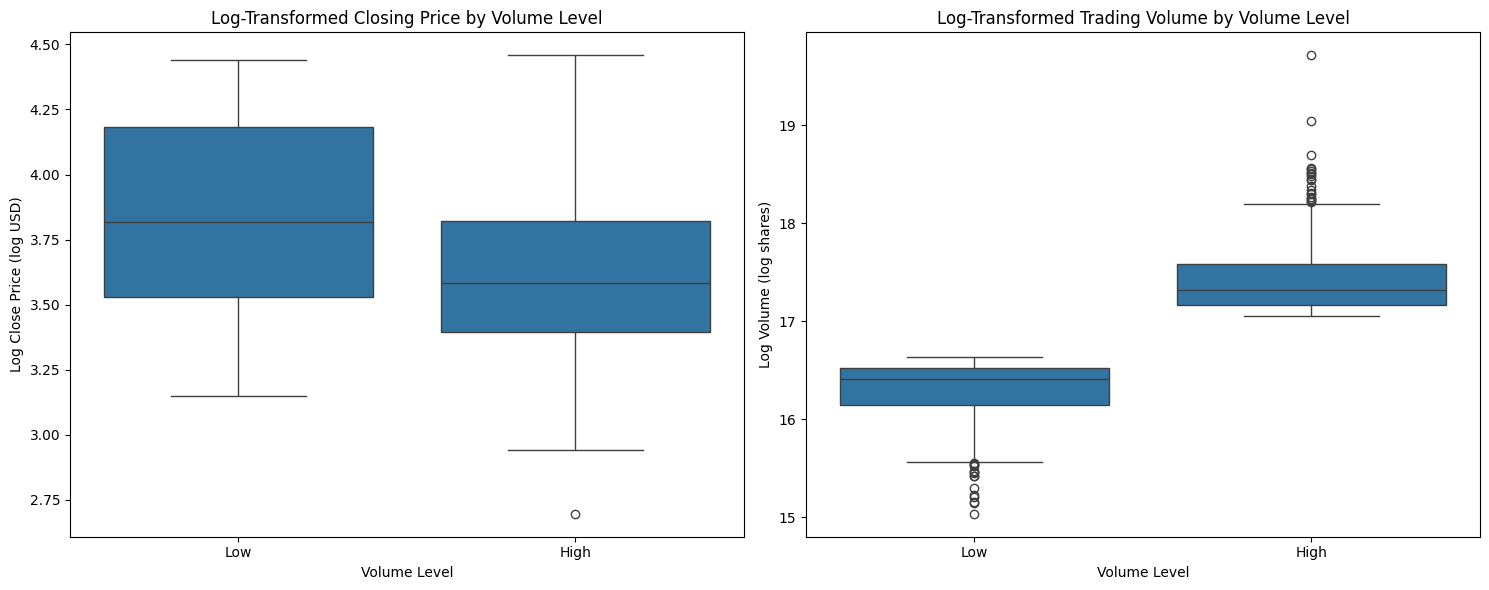

In [95]:
import numpy as np
import pandas as pd
import scipy.stats
from scipy.stats import ttest_ind, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Convert Date to datetime with correct format to fix ValueError
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Ensure Log_Close and Log_Volume are computed
df['Log_Close'] = np.log(df['Close'].clip(lower=1e-10))  # Avoid log(0)
df['Log_Volume'] = np.log(df['Volume'].clip(lower=1e-10))  # Avoid log(0)

# --- Weekday vs. Weekend T-Tests ---
# Create is_weekend column (Friday as 'weekend' proxy, Monday–Thursday as weekday)
df['Weekday'] = df['Date'].dt.day_name()
df['is_weekend'] = df['Weekday'] == 'Friday'

# T-Test 1: Log_Close (Weekday vs. Weekend)
print("\n--- T-Test: Log_Close (Weekday vs. Weekend) ---")

# Extract groups
weekday_log_close = df[df['is_weekend'] == False]['Log_Close']
weekend_log_close = df[df['is_weekend'] == True]['Log_Close']

# Perform independent t-test (Welch’s t-test)
t_stat_close_week, p_value_close_week = ttest_ind(weekday_log_close, weekend_log_close, equal_var=False)

# Define alpha level
alpha = 0.05

# Hypotheses
print("H₀ (Null Hypothesis): There is no significant difference in mean Log_Close between weekdays and weekends.")
print("H₁ (Alternative Hypothesis): There is a significant difference in mean Log_Close between weekdays and weekends.")

# Test result
print(f"\nT-statistic: {t_stat_close_week:.3f}")
print(f"P-value: {p_value_close_week:.3f}")

# Conclusion
if p_value_close_week < alpha:
    print(f"\nConclusion: Since p-value < {alpha}, we reject the null hypothesis (H₀).")
    print("Mean Log_Close is significantly different between weekdays and weekends.")
else:
    print(f"\nConclusion: Since p-value ≥ {alpha}, we fail to reject the null hypothesis (H₀).")
    print("Mean Log_Close is NOT significantly different between weekdays and weekends.")

# T-Test 2: Log_Volume (Weekday vs. Weekend)
print("\n--- T-Test: Log_Volume (Weekday vs. Weekend) ---")

# Extract groups
weekday_log_volume = df[df['is_weekend'] == False]['Log_Volume']
weekend_log_volume = df[df['is_weekend'] == True]['Log_Volume']

# Perform independent t-test (Welch’s t-test)
t_stat_volume_week, p_value_volume_week = ttest_ind(weekday_log_volume, weekend_log_volume, equal_var=False)

# Hypotheses
print("H₀ (Null Hypothesis): There is no significant difference in mean Log_Volume between weekdays and weekends.")
print("H₁ (Alternative Hypothesis): There is a significant difference in mean Log_Volume between weekdays and weekends.")

# Test result
print(f"\nT-statistic: {t_stat_volume_week:.3f}")
print(f"P-value: {p_value_volume_week:.3f}")

# Conclusion
if p_value_volume_week < alpha:
    print(f"\nConclusion: Since p-value < {alpha}, we reject the null hypothesis (H₀).")
    print("Mean Log_Volume is significantly different between weekdays and weekends.")
else:
    print(f"\nConclusion: Since p-value ≥ {alpha}, we fail to reject the null hypothesis (H₀).")
    print("Mean Log_Volume is NOT significantly different between weekdays and weekends.")

# Visualization: Box Plots for Weekday vs. Weekend
print("\nVisualizing Weekday vs. Weekend differences...")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(x='is_weekend', y='Log_Close', data=df, ax=axes[0])
axes[0].set_title('Log-Transformed Closing Price by Weekday/Weekend')
axes[0].set_xlabel('Is Weekend (Friday)')
axes[0].set_ylabel('Log Close Price (log USD)')
axes[0].set_xticklabels(['Weekday (Mon–Thu)', 'Weekend (Fri)'])
sns.boxplot(x='is_weekend', y='Log_Volume', data=df, ax=axes[1])
axes[1].set_title('Log-Transformed Trading Volume by Weekday/Weekend')
axes[1].set_xlabel('Is Weekend (Friday)')
axes[1].set_ylabel('Log Volume (log shares)')
axes[1].set_xticklabels(['Weekday (Mon–Thu)', 'Weekend (Fri)'])
plt.tight_layout()
plt.savefig('weekday_weekend_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

# --- High vs. Low Volume T-Tests ---
# Create Volume_Level
df['Volume_Level'] = pd.qcut(df['Volume'], q=3, labels=['Low', 'Medium', 'High'])

# T-Test 3: Log_Close (High vs. Low Volume Days)
print("\n--- T-Test: Log_Close (High vs. Low Volume Days) ---")

# Extract groups (exclude Medium)
high_volume_close = df[df['Volume_Level'] == 'High']['Log_Close']
low_volume_close = df[df['Volume_Level'] == 'Low']['Log_Close']

# Perform independent t-test (Welch’s t-test)
t_stat_close_vol, p_value_close_vol = ttest_ind(high_volume_close, low_volume_close, equal_var=False)

# Hypotheses
print("H₀ (Null Hypothesis): There is no significant difference in mean Log_Close between high and low volume days.")
print("H₁ (Alternative Hypothesis): There is a significant difference in mean Log_Close between high and low volume days.")

# Test result
print(f"\nT-statistic: {t_stat_close_vol:.3f}")
print(f"P-value: {p_value_close_vol:.4e}")

# Conclusion
if p_value_close_vol < alpha:
    print(f"\nConclusion: Since p-value < {alpha}, we reject the null hypothesis (H₀).")
    print("Mean Log_Close is significantly different between high and low volume days.")
else:
    print(f"\nConclusion: Since p-value ≥ {alpha}, we fail to reject the null hypothesis (H₀).")
    print("Mean Log_Close is NOT significantly different between high and low volume days.")

# T-Test 4: Log_Volume (High vs. Low Volume Days)
print("\n--- T-Test: Log_Volume (High vs. Low Volume Days) ---")

# Extract groups (exclude Medium)
high_volume_vol = df[df['Volume_Level'] == 'High']['Log_Volume']
low_volume_vol = df[df['Volume_Level'] == 'Low']['Log_Volume']

# Perform independent t-test (Welch’s t-test)
t_stat_volume_vol, p_value_volume_vol = ttest_ind(high_volume_vol, low_volume_vol, equal_var=False)

# Hypotheses
print("H₀ (Null Hypothesis): There is no significant difference in mean Log_Volume between high and low volume days.")
print("H₁ (Alternative Hypothesis): There is a significant difference in mean Log_Volume between high and low volume days.")

# Test result
print(f"\nT-statistic: {t_stat_volume_vol:.3f}")
print(f"P-value: {p_value_volume_vol:.4e}")

# Conclusion
if p_value_volume_vol < alpha:
    print(f"\nConclusion: Since p-value < {alpha}, we reject the null hypothesis (H₀).")
    print("Mean Log_Volume is significantly different between high and low volume days.")
else:
    print(f"\nConclusion: Since p-value ≥ {alpha}, we fail to reject the null hypothesis (H₀).")
    print("Mean Log_Volume is NOT significantly different between high and low volume days.")

# Visualization: Box Plots for High vs. Low Volume Days
print("\nVisualizing High vs. Low Volume differences...")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(x='Volume_Level', y='Log_Close', data=df[df['Volume_Level'].isin(['Low', 'High'])],
            order=['Low', 'High'], ax=axes[0])
axes[0].set_title('Log-Transformed Closing Price by Volume Level')
axes[0].set_xlabel('Volume Level')
axes[0].set_ylabel('Log Close Price (log USD)')
sns.boxplot(x='Volume_Level', y='Log_Volume', data=df[df['Volume_Level'].isin(['Low', 'High'])],
            order=['Low', 'High'], ax=axes[1])
axes[1].set_title('Log-Transformed Trading Volume by Volume Level')
axes[1].set_xlabel('Volume Level')
axes[1].set_ylabel('Log Volume (log shares)')
plt.tight_layout()
plt.savefig('high_low_volume_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

## **Chi-Square Test: Price_Level vs. Volume_Level**

This section performs a chi-square test of independence to assess whether `Price_Level` (Low, Medium, High, based on tertiles of `Close`) and `Volume_Level` (Low, Medium, High, based on tertiles of `Volume`) are associated. The test examines whether the distribution of price levels depends on volume levels, complementing correlation and ANOVA analyses. A heatmap of the contingency table visualizes the observed frequencies, supporting the test results.


--- Chi-Square Test: Price_Level vs. Volume_Level ---

Contingency Table:
Volume_Level  Low  Medium  High
Price_Level                    
Low           115     162   206
Medium        156     154   169
High          210     165   107

H₀ (Null Hypothesis): Price_Level and Volume_Level are independent (no association).
H₁ (Alternative Hypothesis): Price_Level and Volume_Level are not independent (there is an association).

Chi-Square Statistic: 59.724
P-value: 3.3152e-12
Degrees of Freedom: 4

Expected Frequencies:
Volume_Level         Low      Medium        High
Price_Level                                     
Low           160.888504  160.888504  161.222992
Medium        159.556094  159.556094  159.887812
High          160.555402  160.555402  160.889197

Conclusion: Since p-value < 0.05, we reject the null hypothesis (H₀).
Price_Level and Volume_Level are significantly associated.

Visualizing contingency table...


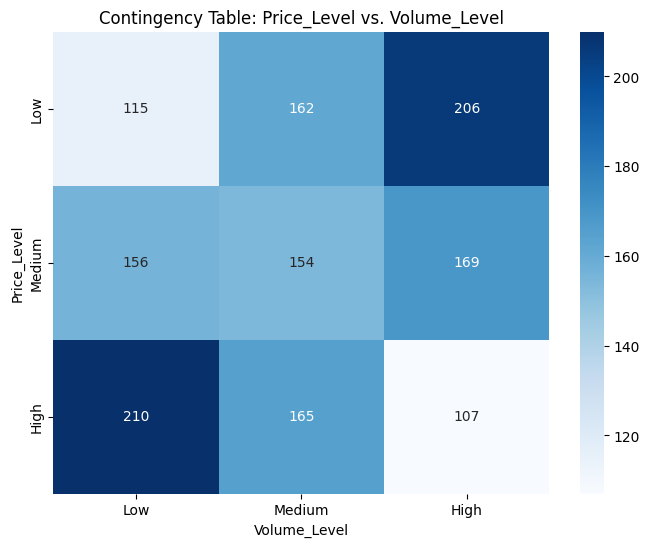

In [96]:
import numpy as np
import pandas as pd
import scipy.stats
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# Create categorical variables
df['Price_Level'] = pd.qcut(df['Close'], q=3, labels=['Low', 'Medium', 'High'])
df['Volume_Level'] = pd.qcut(df['Volume'], q=3, labels=['Low', 'Medium', 'High'])

# Create contingency table
contingency_table = pd.crosstab(df['Price_Level'], df['Volume_Level'])
print("\n--- Chi-Square Test: Price_Level vs. Volume_Level ---")
print("\nContingency Table:")
print(contingency_table)

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Define alpha level
alpha = 0.05

# Hypotheses
print("\nH₀ (Null Hypothesis): Price_Level and Volume_Level are independent (no association).")
print("H₁ (Alternative Hypothesis): Price_Level and Volume_Level are not independent (there is an association).")

# Test result
print(f"\nChi-Square Statistic: {chi2_stat:.3f}")
print(f"P-value: {p_value:.4e}")
print(f"Degrees of Freedom: {dof}")

# Check expected frequencies
print("\nExpected Frequencies:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

# Conclusion
if p_value < alpha:
    print(f"\nConclusion: Since p-value < {alpha}, we reject the null hypothesis (H₀).")
    print("Price_Level and Volume_Level are significantly associated.")
else:
    print(f"\nConclusion: Since p-value ≥ {alpha}, we fail to reject the null hypothesis (H₀).")
    print("Price_Level and Volume_Level are NOT significantly associated.")

# Visualization: Heatmap of Contingency Table
print("\nVisualizing contingency table...")
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Contingency Table: Price_Level vs. Volume_Level')
plt.xlabel('Volume_Level')
plt.ylabel('Price_Level')
plt.show()

# **Chi-Square Test: Close_Category vs. Volume_Category**

This section performs a chi-square test of independence to assess whether `Close_Category` (Low, Medium, High, based on tertiles of `Close`) and `Volume_Category` (Low Volume, High Volume, based on the median of `Volume`) are associated.
The test examines whether stock price categories are related to trading volume categories, complementing the chi-square test for `Price_Level` vs. `Volume_Level` and multivariate analyses.
A heatmap of the 3x2 contingency table visualizes the observed frequencies, supporting the test results.


--- Chi-Square Test: Close_Category vs. Volume_Category ---

Contingency Table:
Volume_Category  High Volume  Low Volume
Close_Category                          
Low                      297         186
Medium                   252         227
High                     173         309

H₀ (Null Hypothesis): Close_Category and Volume_Category are independent (no association).
H₁ (Alternative Hypothesis): Close_Category and Volume_Category are not independent (there is an association).

Chi-Square Statistic: 65.188
P-value: 6.9936e-15
Degrees of Freedom: 2

Expected Frequencies:
Volume_Category  High Volume  Low Volume
Close_Category                          
Low                    241.5       241.5
Medium                 239.5       239.5
High                   241.0       241.0

Conclusion: Since p-value < 0.05, we reject the null hypothesis (H₀).
Close_Category and Volume_Category are significantly associated.

Visualizing contingency table...


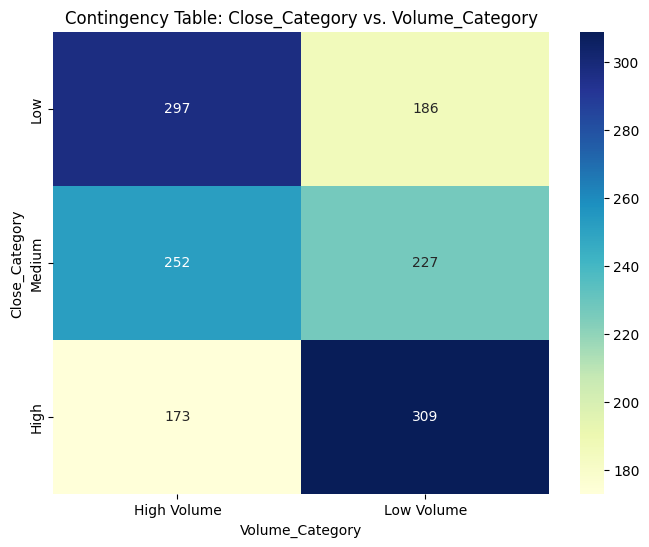

In [97]:
import numpy as np
import pandas as pd
import scipy.stats
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# Create categorical variables
df['Close_Category'] = pd.qcut(df['Close'], q=3, labels=['Low', 'Medium', 'High'])
median_volume = df['Volume'].median()
df['Volume_Category'] = df['Volume'].apply(lambda x: 'High Volume' if x > median_volume else 'Low Volume')

# Create contingency table
contingency_table = pd.crosstab(df['Close_Category'], df['Volume_Category'])
print("\n--- Chi-Square Test: Close_Category vs. Volume_Category ---")
print("\nContingency Table:")
print(contingency_table)

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Define alpha level
alpha = 0.05

# Hypotheses
print("\nH₀ (Null Hypothesis): Close_Category and Volume_Category are independent (no association).")
print("H₁ (Alternative Hypothesis): Close_Category and Volume_Category are not independent (there is an association).")

# Test result
print(f"\nChi-Square Statistic: {chi2_stat:.3f}")
print(f"P-value: {p_value:.4e}")
print(f"Degrees of Freedom: {dof}")

# Check expected frequencies
print("\nExpected Frequencies:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

# Conclusion
if p_value < alpha:
    print(f"\nConclusion: Since p-value < {alpha}, we reject the null hypothesis (H₀).")
    print("Close_Category and Volume_Category are significantly associated.")
else:
    print(f"\nConclusion: Since p-value ≥ {alpha}, we fail to reject the null hypothesis (H₀).")
    print("Close_Category and Volume_Category are NOT significantly associated.")

# Visualization: Heatmap of Contingency Table
print("\nVisualizing contingency table...")
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Contingency Table: Close_Category vs. Volume_Category')
plt.xlabel('Volume_Category')
plt.ylabel('Close_Category')
plt.savefig('close_volume_category_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# **Chi-Square Test : Volume Buckets vs Weekday**


H₀ (Null Hypothesis): Volume_Buckets and Weekday are independent (no association).
H₁ (Alternative Hypothesis): Volume_Buckets and Weekday are not independent (there is an association).

Chi-Square Statistic: 65.188
P-value: 6.9936e-15
Degrees of Freedom: 2

Expected Frequencies:
Volume_Category  High Volume  Low Volume
Close_Category                          
Low                    241.5       241.5
Medium                 239.5       239.5
High                   241.0       241.0

Conclusion: Since p-value < 0.05, we reject the null hypothesis (H₀).
Volume_Buckets and Weekday are significantly associated.

Visualizing contingency table...


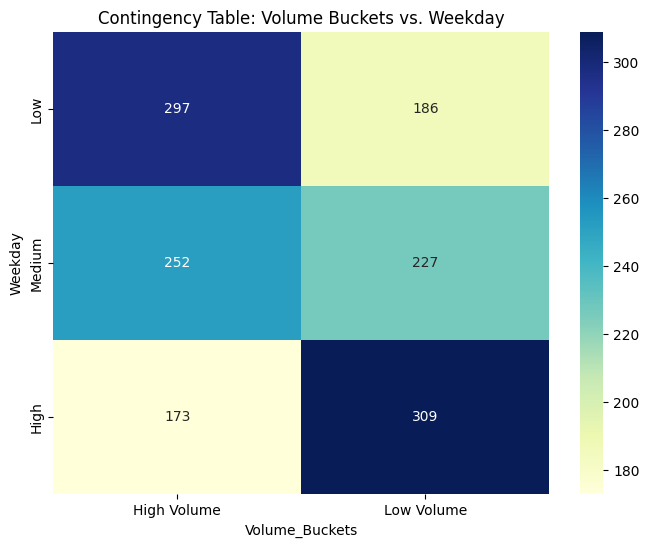

In [98]:
import numpy as np
import pandas as pd
import scipy.stats
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# Create categorical variables
df['Weekday'] = df['Date'].dt.day_name()
df['Volume_Buckets'] = pd.qcut(df['Volume'], q=3, labels=['Low', 'Medium', 'High'])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Define alpha level
alpha = 0.05

# Hypotheses
print("\nH₀ (Null Hypothesis): Volume_Buckets and Weekday are independent (no association).")
print("H₁ (Alternative Hypothesis): Volume_Buckets and Weekday are not independent (there is an association).")

# Test result
print(f"\nChi-Square Statistic: {chi2_stat:.3f}")
print(f"P-value: {p_value:.4e}")
print(f"Degrees of Freedom: {dof}")

# Check expected frequencies
print("\nExpected Frequencies:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

# Conclusion
if p_value < alpha:
    print(f"\nConclusion: Since p-value < {alpha}, we reject the null hypothesis (H₀).")
    print("Volume_Buckets and Weekday are significantly associated.")
else:
    print(f"\nConclusion: Since p-value ≥ {alpha}, we fail to reject the null hypothesis (H₀).")
    print("Volume_Buckets and Weekday are NOT significantly associated.")

# Visualization: Heatmap of Contingency Table
print("\nVisualizing contingency table...")
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Contingency Table: Volume Buckets vs. Weekday')
plt.xlabel('Volume_Buckets')
plt.ylabel('Weekday')
plt.savefig('volume_weekday_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# **Anova Tests**

This section conducts ANOVA tests to assess the impact of temporal factors (e.g., Market Period, Year, Weekday) on Uber's stock price (`Close`, `Log_Close`) and trading volume (`Volume`, `Log_Volume`). The tests include:
- **One-Way ANOVA**: Tests the effect of a single categorical variable (e.g., Market Period) on `Close` or `Log_Close`.
- **Two-Way ANOVA**: Tests the effects of two categorical variables (e.g., Weekday and Year) and their interaction.
- **ANCOVA**: Tests the effect of a categorical variable (e.g., Market Period) while controlling for a covariate (e.g., Volume).

These tests extend the statistical analysis by examining mean differences across groups, supporting the project's goal to understand factors driving stock performance.



Market_Period Distribution:
Market_Period
Post-COVID    904
COVID         337
Pre-COVID     202
NaN             1
Name: count, dtype: int64

Levene’s Test for Homogeneity of Variances (Close by Market_Period):
LeveneResult(statistic=np.float64(107.11867961925786), pvalue=np.float64(4.271304474737037e-44))

One-Way ANOVA: Close by Market Period
                      df         sum_sq       mean_sq          F        PR(>F)
C(Market_Period)     2.0   24332.551312  12166.275656  53.646931  3.377353e-23
Residual          1440.0  326569.230865    226.784188        NaN           NaN
Conclusion: p-value < 0.05 indicates significant differences in Close across Market Periods.

One-Way ANOVA: Log_Close by Year
              df      sum_sq    mean_sq           F  PR(>F)
C(Year)      6.0  127.237615  21.206269  723.018724     0.0
Residual  1437.0   42.147468   0.029330         NaN     NaN
Conclusion: p-value < 0.05 indicates significant differences in Log_Close across Years.

Two-Way ANOVA: Close

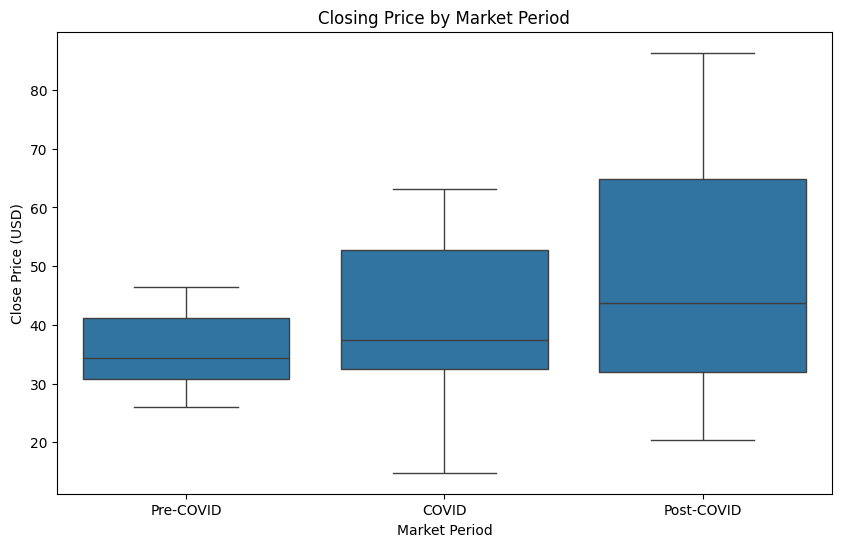

In [99]:
import numpy as np
import pandas as pd
from scipy.stats import levene, chi2_contingency
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is the DataFrame with Uber stock data (Date, Close, Volume)

# Create categorical variables
df['Weekday'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month_name()
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter
df['Market_Period'] = pd.cut(df['Date'],
                             bins=[pd.to_datetime('2019-05-10'), pd.to_datetime('2020-03-01'),
                                   pd.to_datetime('2021-06-30'), pd.to_datetime('2025-02-05')],
                             labels=['Pre-COVID', 'COVID', 'Post-COVID'])

# Create Log_Close if not already defined
if 'Log_Close' not in df.columns:
    df['Log_Close'] = np.log(df['Close'].replace(0, np.nan))  # Avoid log(0)

# Check Market_Period distribution to diagnose Levene's test issue
print("\nMarket_Period Distribution:")
print(df['Market_Period'].value_counts(dropna=False))

# Levene's test for homogeneity of variances (with error handling)
groups = [df['Close'][df['Market_Period'] == level] for level in df['Market_Period'].unique() if not df['Market_Period'][df['Market_Period'] == level].empty]
if all(len(group) > 1 for group in groups):
    levene_test = levene(*groups)
    print("\nLevene’s Test for Homogeneity of Variances (Close by Market_Period):")
    print(levene_test)
else:
    print("\nLevene’s Test skipped: One or more Market_Period groups have insufficient data (<=1 sample).")

# One-Way ANOVA: Close by Market Period
model_oneway = ols('Close ~ C(Market_Period)', data=df).fit()
anova_oneway = anova_lm(model_oneway)
print("\nOne-Way ANOVA: Close by Market Period")
print(anova_oneway)
print("Conclusion: p-value < 0.05 indicates significant differences in Close across Market Periods.")

# One-Way ANOVA: Log_Close by Year
model_oneway_year = ols('Log_Close ~ C(Year)', data=df).fit()
anova_oneway_year = anova_lm(model_oneway_year)
print("\nOne-Way ANOVA: Log_Close by Year")
print(anova_oneway_year)
print("Conclusion: p-value < 0.05 indicates significant differences in Log_Close across Years.")

# Two-Way ANOVA: Close by Weekday and Year
model_twoway = ols('Close ~ C(Weekday) + C(Year) + C(Weekday):C(Year)', data=df).fit()
anova_twoway = anova_lm(model_twoway)
print("\nTwo-Way ANOVA: Close by Weekday and Year")
print(anova_twoway)
print("Conclusion: p-value < 0.05 for main effects or interaction indicates significant effects.")

# ANCOVA: Close by Market Period, controlling for Volume
model_ancova = ols('Close ~ C(Market_Period) + Volume', data=df).fit()
anova_ancova = anova_lm(model_ancova)
print("\nANCOVA: Close by Market Period, controlling for Volume")
print(anova_ancova)
print("Conclusion: p-value < 0.05 for Market_Period indicates significant effect after controlling for Volume.")

# Visualization: Box Plot for Close by Market Period
plt.figure(figsize=(10, 6))
sns.boxplot(x='Market_Period', y='Close', data=df)
plt.title('Closing Price by Market Period')
plt.xlabel('Market Period')
plt.ylabel('Close Price (USD)')
plt.show()


# **Simple Linear Regression: Close ~ Open**

In [100]:
# Simple Linear Regression: Close ~ Open
X = df['Open']
y = df['Close']
X = sm.add_constant(X)
model_simple = sm.OLS(y, X).fit()
print("\n--- Simple Linear Regression Summary: Close ~ Open ---")
print(model_simple.summary())


--- Simple Linear Regression Summary: Close ~ Open ---
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 3.001e+05
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        19:21:14   Log-Likelihood:                -2157.4
No. Observations:                1444   AIC:                             4319.
Df Residuals:                    1442   BIC:                             4329.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

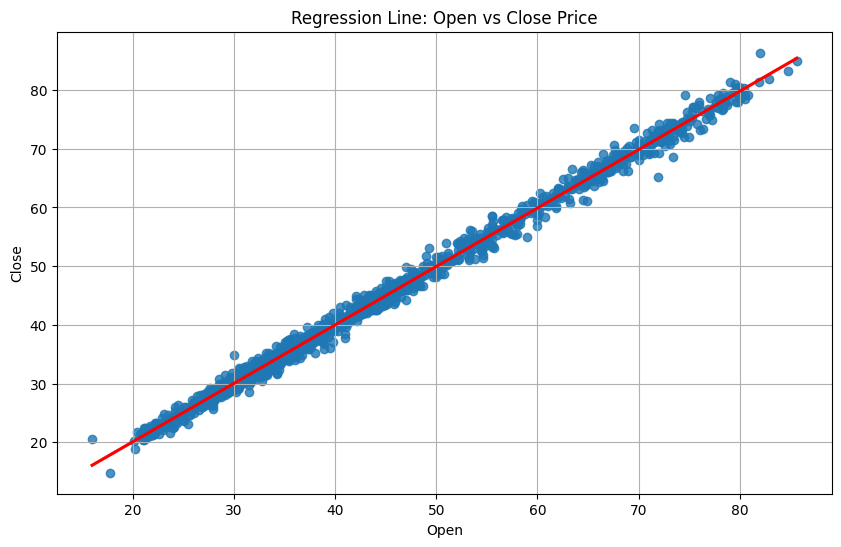

In [101]:
# Regression Line Plot
plt.figure(figsize=(10,6))
sns.regplot(x='Open', y='Close', data=df, line_kws={"color":"red"})
plt.title('Regression Line: Open vs Close Price')
plt.grid(True)
plt.show()

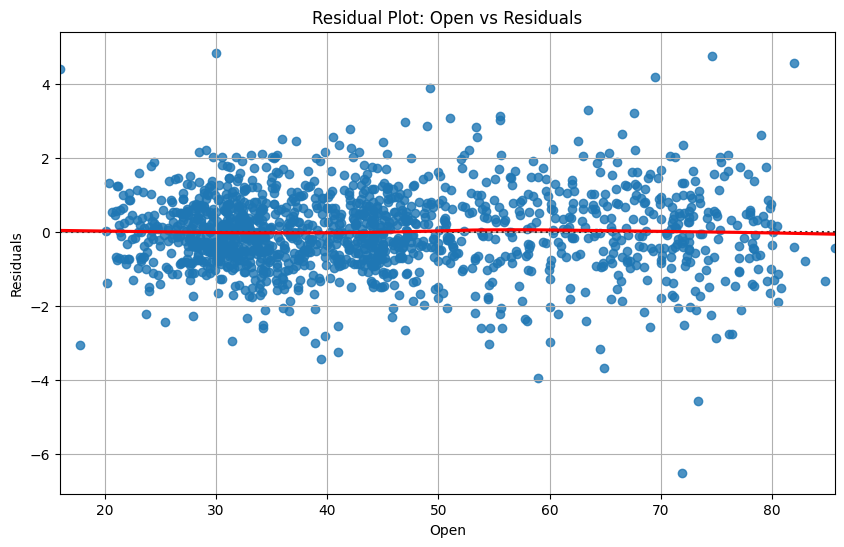

In [102]:
# Residual Plot
residuals = model_simple.resid
plt.figure(figsize=(10,6))
sns.residplot(x=df['Open'], y=residuals, lowess=True, line_kws={'color': 'red'})
plt.title('Residual Plot: Open vs Residuals')
plt.xlabel('Open')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictions from the model
predicted_close = model_simple.fittedvalues
actual_close = y

# Performance Metrics
mse = mean_squared_error(actual_close, predicted_close)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_close, predicted_close)
r2 = r2_score(actual_close, predicted_close)

print("\n--- Regression Performance Metrics (Simple Linear Regression) ---")
print(f"R² Score       : {r2:.4f}")
print(f"MSE            : {mse:.4f}")
print(f"RMSE           : {rmse:.4f}")


--- Regression Performance Metrics (Simple Linear Regression) ---
R² Score       : 0.9952
MSE            : 1.1620
RMSE           : 1.0780


# **Multiple Linear Regression: Close ~ Open + High + Low + Volume**

In [104]:
# Multiple Linear Regression: Close ~ Open + High + Low + Volume
features = ['Open', 'High', 'Low', 'Volume']
if all(f in df.columns for f in features):
    X_multi = df[features]
    y_multi = df['Close']
    X_multi = sm.add_constant(X_multi)
    model_multi = sm.OLS(y_multi, X_multi).fit()
    print("\n--- Multiple Linear Regression Summary: Close ~ Open + High + Low + Volume ---")
    print(model_multi.summary())


--- Multiple Linear Regression Summary: Close ~ Open + High + Low + Volume ---
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.871e+05
Date:                Wed, 07 May 2025   Prob (F-statistic):               0.00
Time:                        19:21:15   Log-Likelihood:                -973.97
No. Observations:                1444   AIC:                             1958.
Df Residuals:                    1439   BIC:                             1984.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

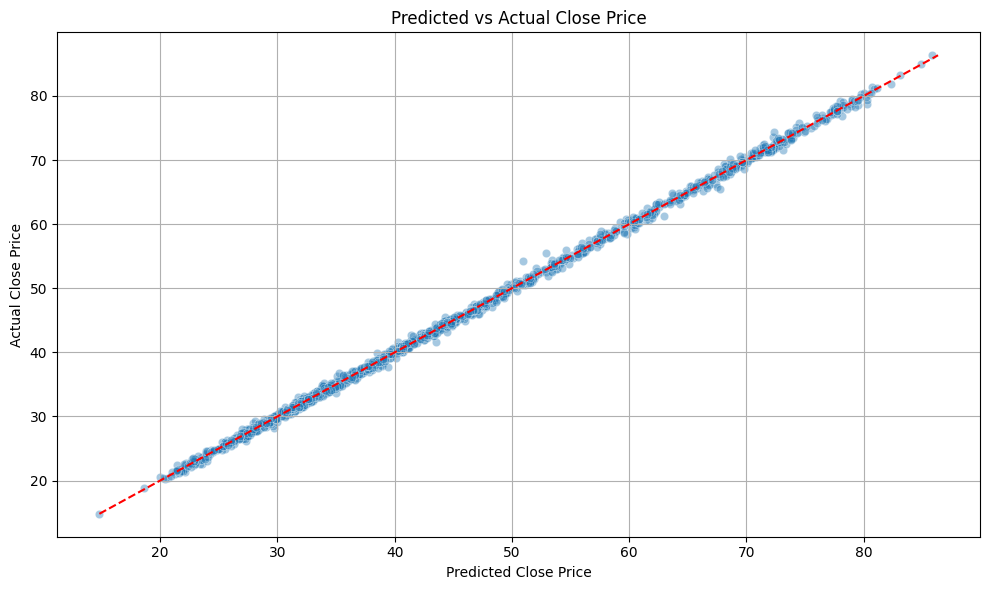

In [105]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict values using fitted model
fitted_close = model_multi.fittedvalues
actual_close = y_multi  # This is your actual Close price
residuals_multi = model_multi.resid

# Plot: Predicted vs Actual Close Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_close, y=actual_close, alpha=0.4)
plt.plot([actual_close.min(), actual_close.max()],
         [actual_close.min(), actual_close.max()],
         color='red', linestyle='--')
plt.title("Predicted vs Actual Close Price")
plt.xlabel("Predicted Close Price")
plt.ylabel("Actual Close Price")
plt.tight_layout()
plt.grid(True)
plt.show()


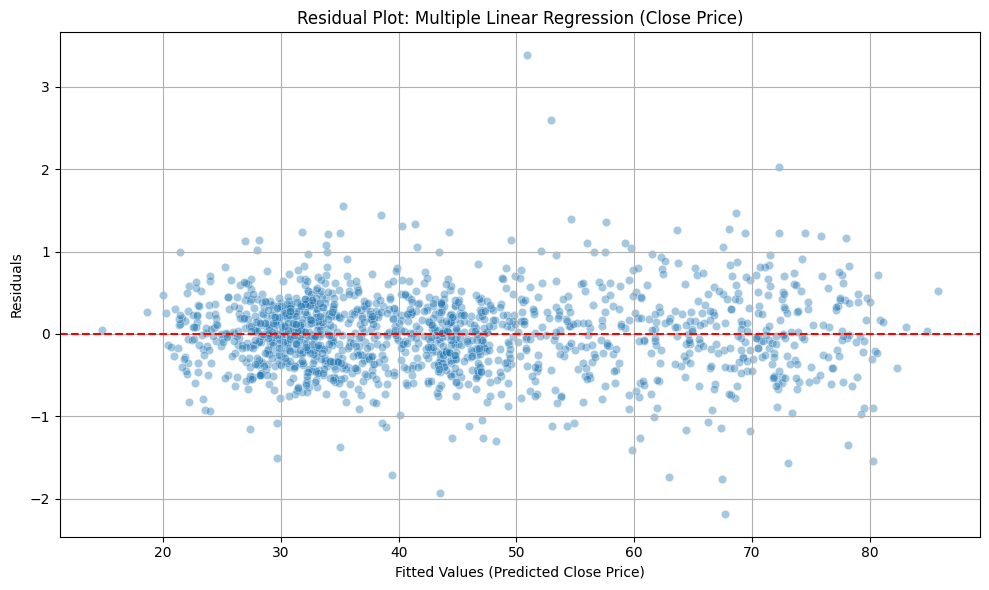

In [106]:
# Plot: Residuals vs Fitted Values for Close Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_close, y=residuals_multi, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot: Multiple Linear Regression (Close Price)")
plt.xlabel("Fitted Values (Predicted Close Price)")
plt.ylabel("Residuals")
plt.tight_layout()
plt.grid(True)
plt.show()


In [109]:
print("\n--- Regression Performance Metrics (Multiple Linear Regression) ---")
print("Mean Squared Error:", mean_squared_error(actual_close, fitted_close))
print("Mean Absolute Error:", mean_absolute_error(actual_close, fitted_close))
print("R² Score:", r2_score(actual_close, fitted_close))


--- Regression Performance Metrics (Multiple Linear Regression) ---
Mean Squared Error: 0.2256236134748428
Mean Absolute Error: 0.3572539494261656
R² Score: 0.9990715558435858
